
**NAMES :  Kim ANTUNEZ, Isabelle BERNARD (Group : Mr Denis)**

<h1><center> TP1 : Basic functions for Supervised Machine Learning. </center></h1>

The deadline for report submission is Tuesday, November 10th 2020.

Note: the goal of this first TP is to become familiar with 'sklearn' class in Python. In particular, we introduce most popular supervised learning algorithms. 

PART 1 is a list of commands that should be followed step by step. PART 2 is an open problem for which we are waiting for your creativity!

## Imported packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, confusion_matrix


%matplotlib notebook

In [2]:
import random
random.seed(1) #to fix random and have the same results for both of us 

#  PART 1 -- MNIST


In the first part of TP1 we pursue the following goals:
1. Apply standard ML algorithms on a standard benchmark data
2. Learn basic means of data visualizations
3. Get familiar with sklearn's GridSearchCV and Pipeline

## Loading the data

MNIST dataset consists of black and white images of hand-written digits from $0$ to $9$ of size $28 \times 28$.
In this exercise we will work with a small from the original MNIST dataset. 

If you are interested in the whole dataset, execute the following commands
```python
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

Hence, the observations $(X_1, Y_1), \ldots, (X_n, Y_n)$ are such that $X_i \in \mathbb{R}^{784}$ and $Y_i \in \{0, \ldots, 9\}$. To be more precise, each component of vector $X_i$ is a number between $0$ and $255$, which signifies the intensity of black color.

The initial goal is to build a classifier $\hat g$, which receives a new image $X$ and outputs the number that is present on the image.

In [3]:
X_train = np.load('data/mnist1_features_train.npy', allow_pickle=True)
y_train = np.load('data/mnist1_labels_train.npy', allow_pickle=True)
X_test = np.load('data/mnist1_features_test.npy', allow_pickle=True)
y_test = np.load('data/mnist1_labels_test.npy', allow_pickle=True)

n_samples, n_features = X_train.shape # extract dimensions of the design matrix
print('Train data contains: {} samples of dimension {}'.format(n_samples, n_features))
print('Test data contains: {} samples'.format(X_test.shape[0]))

Train data contains: 2000 samples of dimension 784
Test data contains: 200 samples


## Looking at the data

Since each observation is actually an image, we can visualize it.

<IPython.core.display.Javascript object>


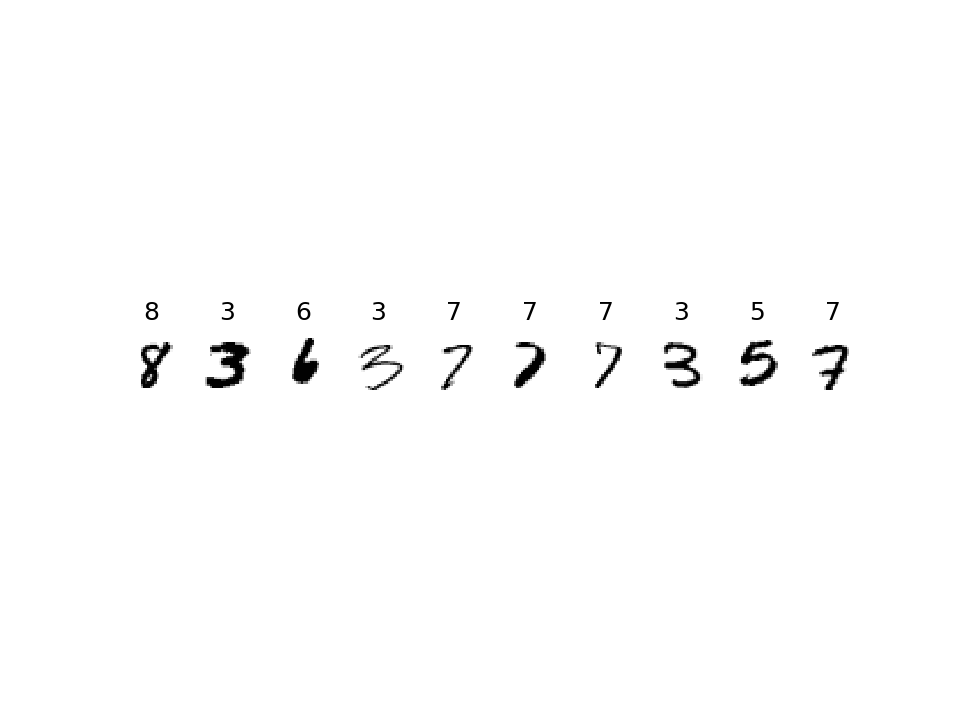

In [4]:
axes = plt.subplots(1, 10)[1]  # creates a grid of 10 plots

# More details about zip() function here 
# https://docs.python.org/3.3/library/functions.html#zip
images_and_labels = list(zip(X_train, y_train)) 
for ax, (image, label) in zip(axes, images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('{}'.format(label))

In [10]:
for i in range(10):
    print('Number of {}s in the train dataset is {}'.format(i, np.sum([y_train == str(i)])))

Number of 0s in the train dataset is 196
Number of 1s in the train dataset is 226
Number of 2s in the train dataset is 214
Number of 3s in the train dataset is 211
Number of 4s in the train dataset is 187
Number of 5s in the train dataset is 179
Number of 6s in the train dataset is 175
Number of 7s in the train dataset is 225
Number of 8s in the train dataset is 186
Number of 9s in the train dataset is 201


From the above we conclude that the dataset is rather balanced, that is, each class contains similar amount of observations. The rarest class is $y = 6$ with $175$ examples and the most common class is $y = 1$ with $226$ examples

## Cross-validation with GridSearchCV

**Question:** Explain in your report what happens when we run ```clf.fit(X_train, y_train)```
What is the complexity for each of the three following cases? 

**Answer :**  
The general objective here is to obtain a first classifier with the **KNN method**. To do that, we test different parameters of the KNN methods and choose the bests using a **cross validation**. That is to say that we test the KNN method by varying the number of neighbors from 1 to 5. The cross validation method used is called **the 3-fold Cross Validation** (CV) following those different steps:
1. we divide our training sample into 3 training sub-samples
2. we train the model on 2 samples and test it on the third one
3. we choose the parameter which has the best average test accuracy (see definition later) on the 3 samples.

**clf.fit(X_train, y_train)** applies what is described above to the training sample. It fits the model (learns from it) using X_train as training data and y_train as target values. The first clf (for classifier) used here is "KNeighborsClassifier" that is to say the k-nearest neighbors vote.

Let's imagine that you train a model on n points and it takes x minutes. If you train it on kn points, it takes kx minutes if the training time is linear, but sometimes it is more. For example, if it takes k2x, the training time is quadratic in the number of points. That is what we call the **complexity** of an algorithm. The question here is very broad (not very precise), because there are at least two different kinds of complexities : **training complexity and prediction complexity**. 

We define the complexity using a Big-O measure. It provides us with an asymptotic upper bound for the growth rate of the runtime of the chosen algorithm. Calling n the number of training samples and p the number of features the complexity predicted for the three methods are : 

* For the **knn** classifier : The parameter used for the algorithm is here ‘auto’. It selects ‘kd_tree’ if $k < N/2$ and the ‘effective_metric_’ is in the ‘VALID_METRICS’ list of ‘kd_tree’. It selects ‘ball_tree’ if k < N/2 and the ‘effective_metric_’ is not in the ‘VALID_METRICS’ list of ‘kd_tree’. It selects ‘brute’ if k >= N/2. For the brute-force method there is no training, (training complexity = $O(1)$),  but classifying has a high cost ($O(knp)$). kd-tree and ball_tree are $O(pnlog(n))$ for training and $O(klog(n))$ for prediction. 
. See precisions [here](https://towardsdatascience.com/k-nearest-neighbors-computational-complexity-502d2c440d5) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). 

* Support Vector Machines (**SVM**) are powerful tools, but their compute and storage requirements increase rapidly with the number of training vectors. The core of an SVM is a quadratic programming problem (QP), separating support vectors from the rest of the training data. The QP solver used by the libsvm-based implementation (`SVC` function) scales between O($pn^2$) and O($pn^3$) depending on how efficiently the libsvm cache is used in practice (dataset dependent). But recent approaches like [this one](https://www.cs.huji.ac.il/~shais/papers/SSSICML08.pdf) are inverse in the size of the training set. In the case of the `LinearSVC` method used in this "TP", it is indicated in the [documentation](https://scikit-learn.org/stable/modules/svm.html#complexity) that the implementation is much more efficient than its libsvm-based `SVC` counterpart and it's training complexity is $O(pn)$ and prediction one remains $O(n_{sv}*p)$ with $n_{sv}$ the number of Support Vectors.

* For **logistic regressions**, training complexity is $O(np)$ and prediction one is $O(p)$. See proof [here](https://levelup.gitconnected.com/train-test-complexity-and-space-complexity-of-logistic-regression-2cb3de762054).

*Main sources : [here](https://medium.com/@paritoshkumar_5426/time-complexity-of-ml-models-4ec39fad2770) and [here](https://www.thekerneltrip.com/machine/learning/computational-complexity-learning-algorithms/)*.

In [261]:
# GridSearchCV with kNN : a simple baseline
knn = KNeighborsClassifier() # defining classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space

In [262]:
clf = GridSearchCV(knn, parameters, cv=3) #cross-validation : method 3-fold.

In [263]:
clf.fit(X_train, y_train) #

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [264]:
print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy in train is: 0.891497944721333
Classification accuracy on test is: 0.875


In [265]:
print(confusion_matrix(y_test, clf.predict(X_test)))

[[21  0  0  0  0  0  1  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  2  0  0  0  0]
 [ 0  0  0 19  0  2  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 0  0  0  0  1  7  1  0  1  0]
 [ 0  0  0  0  0  1 23  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  1  0  1  0  0  0  0 14  1]
 [ 1  1  0  0  2  0  0  3  0 19]]


**Question:** What is the test accuracy? What would be the accuracy of random guess?

**Answer :**
Accuracy is the number of correctly predicted data points out of all the data points. The `accuracy_score` function computes the accuracy, either the fraction (default) or the count (`normalize=False`) of correct predictions.

More formally, for a **binary problem** it is defined as the number of true positives (y predicted 1 and with a true value of 1) and true negatives (y predicted 0 and with a true value of 0) divided by the number of true positives, true negatives, false positives (y predicted 1 and with a true value of 0), and false negatives (y predicted 0 and with a true value of 1). 
$$
\texttt{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1; otherwise it is 0.

If $\hat{y}_i$ is the predicted value of the $i$-th sample and $y_i$ is the corresponding true value, then the fraction of correct predictions over is defined as $n_\text{samples}$. Here is the normalized accuracy score : 
$$
\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)
$$
See more details [here](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score) 

The accuracy is used to to determine which model is best at identifying relationships and patterns between variables in a dataset based on the input data or training data. Here we comment the "test accuracy" that is to say the accuracy of the test sample and not on the training sample ! 
The test accuracy  is here **0.875**. On a **random guess it would be 0.1** : one chance to be guess the right number out of 10 possible numbers (10 classes).

In [39]:
#Simple example of accuracy for a multiclass analysis to illustrate.
y_true = [0, 0, 1, 2, 3]
y_pred = [0, 1, 2, 1, 3]
print("accuracy normalisée : ", accuracy_score(y_true, y_pred))
print("accuracy non normalisée : ", accuracy_score(y_true, y_pred, normalize=False))

accuracy normalisée :  0.4
accuracy non normalisée :  2


Indeed, 

$$
\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i) = \frac{1}{5} \sum_{i=0}^{4} 1(\hat{y}_i = y_i) =  \frac{1}{5} * 2 = 0.4
$$


**Question:** What is ``` LinearSVC()``` classifier? Which kernel are we using? What is ```C```? (this is a tricky question, try to find the answer online)

**Answer :** ``` LinearSVC()``` (Linear Support Vector Classification) is a fast implementation of Support Vector Machine Classification (SVM) for the case of a linear kernel. It is similar to `SVC` with parameter `kernel=’linear’`, but implemented in terms of `liblinear` rather than `libsvm`, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.
The main characteristics of this method are : 
- the loss used is the [‘squared_hinge’](https://en.wikipedia.org/wiki/Hinge_loss) (even if it is not indicated in the [general documentation](https://scikit-learn.org/stable/modules/svm.html#linearsvc) which is strange)
- to generate the multiclass problem, ` LinearSVC()` uses `  One-vs-All` (see example [here](http://eric.univ-lyon2.fr/~ricco/cours/slides/svm.pdf), slide 38).

More precisely, given training vectors $x_i \in \mathbb{R}^p$, i=1,…, n, in two classes, and a vector $y \in \{1, -1\}^n$ 
, our goal is to find $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by $\text{sign} (w^T\phi(x) + b)$ is correct for most samples.
LinearSVC solves the following problem:
$\min_ {w, b} \frac{1}{2} w^T w + C \sum_{i=1}\max(0, y_i (w^T \phi(x_i) + b))$,
where we make use of the hinge loss. This is the form that is directly optimized by LinearSVC, but unlike the dual form, this one does not involve inner products between samples, so the famous kernel trick cannot be applied. This is why only the linear kernel is supported by LinearSVC ($\phi$ is the identity function).

The **C parameter** is a regularization or penalty parameter. SVM only work properly if the data is separable. Otherwise, we will penalize the loss of this non-separability (see [here](https://scikit-learn.org/stable/modules/svm.html#svc)) measuring the distance between the misclassified points and the separating hyperplane. C represents misclassification or error term. The misclassification or error term tells the SVM optimisation how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term. 
Concretely, when C is high, we penalize a lot for misclassification, which means that we classify lots of points correctly, also there is a chance to overfit.

Documentation : C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization. LinearSVC and LinearSVR are less sensitive to C when it becomes large, and prediction results stop improving after a certain threshold. Meanwhile, larger C values will take more time to train, sometimes up to 10 times longer.


**Question:** What is the outcome of ```np.logspace(-8, 8, 17, base=2)```? More generally, what is the outcome of ```np.logspace(-a, b, k, base=m)```?

**Answer :** 
```np.logspace(-8, 8, 17, base=2)``` returns 17 numbers spaced evenly on a log scale. The sequence starts at $2^{-8}$ and ends with $2^{8}$.

```np.logspace(-a, b, k, base=m)``` returns k numbers spaced evenly on a log scale (endpoint=True by default). The parameter `base` is the logarithmic base. In linear space, the sequence starts at $m^{-a}$ and ends at $m^b$. 

It is equivalent to
1. divide the interval $[-a,b]$ into $(y_i)_{i=1..k}$ $k$ equidistant points
2. return $\left(m^{y_i}\right)_{i=1..k}$

In [15]:
# SVM Classifier
svc = LinearSVC(max_iter=5000)
parameters2 = {'C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf2 = GridSearchCV(svc, parameters2, cv=3)
clf2.fit(X_train, y_train)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=5000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
print('Returned hyperparameter: {}'.format(clf2.best_params_))
print('Best classification accuracy in train is: {}'.format(clf2.best_score_))
print('Classification accuracy on test is: {}'.format(clf2.score(X_test, y_test)))

Returned hyperparameter: {'C': 0.00390625}
Best classification accuracy in train is: 0.8095074084579332
Classification accuracy on test is: 0.795


**Question** What is the meaning of the warnings? What is the parameter responsible for its appearence?

**Answer :** Warnings are about the fact that the algorithm does not converge considering the maximum number of iterations given. The maximum number of iterations is given by the parameter `max_iter` which is here set to `max_iter=5000`.
In fact, there is no preprocessing (date are not normalize/standardized data). Therefore unscaled data can slow down or even prevent the convergence of many metric-based and gradient-based estimators. Indeed many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales.

In [17]:
# SVM Classifier + Pipeline
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters3 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf3 = GridSearchCV(pipe, parameters3, cv=3)
clf3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler', MaxAbsScaler(copy=True)),
                                       ('svc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=5000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'svc__C': array([3.90625e-03, 7.8125

In [18]:
print('Returned hyperparameter: {}'.format(clf3.best_params_))
print('Best classification accuracy in train is: {}'.format(clf3.best_score_))
print('Classification accuracy on test is: {}'.format(clf3.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy in train is: 0.863002432717575
Classification accuracy on test is: 0.84


**Question:** What did we change with respect to the previous run of ```LinearSVC()```?

**Answer:** A pipeline allows us to perform several operations in a row. First, we renormalize the features with `MaxAbsScaler` (using the training data), in order to put them on the same scale.
This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set will be 1. 

For each i-th component of each vector $(X_j)$, we probably divide by the highest value (in absolute value) that is to say $X'_{i,j}=\frac{X_{i,j}}{X_{i_{max},j}}$ with $i_{max}= \underset{j}{\max}|X_{i,j}|$ .

Second, we apply the same algorithm as before (svc, a LinearSVC) to fit the training data in a 3-fold CV validation (as before) to choose the best value of the C parameter which seems to be `C = 0.015625`. 

**Question:** Explain what happens if we execute
```python
    pipe.fit(X_train, y_train)
    pipe.predict(X_test, y_test)
```
**Answer:**
`pipe.fit` works. It fits the dataset as before but not using a cross-validation but using the default `C` parameter (that is to say ...) and `max_iter=5000`. 


`pipe.predict` returns the following error : `TypeError: predict() takes 2 positional arguments but 3 were given`

The function does not work here because when we do a prevision, we do not need to enter the `Y` values, we just need the `X` ones. 
This is why the following lines work (see below). 
```python
    pipe.predict(X_test) #working
    pipe.score(X_test, y_test)  #working
```

In [19]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MaxAbsScaler(copy=True)),
                ('svc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=5000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [20]:
pipe.predict(X_test, y_test) #not working

TypeError: predict() takes 2 positional arguments but 3 were given

In [24]:
pipe.predict(X_test) #working

array(['4', '1', '6', '5', '3', '4', '1', '3', '3', '1', '0', '6', '3',
       '4', '9', '7', '6', '4', '1', '6', '1', '4', '3', '8', '9', '4',
       '7', '8', '1', '1', '5', '6', '1', '4', '0', '2', '0', '9', '9',
       '6', '2', '4', '6', '4', '9', '8', '7', '7', '0', '9', '4', '6',
       '9', '7', '5', '2', '2', '7', '1', '6', '5', '4', '2', '8', '9',
       '6', '3', '2', '8', '1', '7', '0', '1', '3', '2', '0', '9', '0',
       '0', '0', '1', '0', '8', '7', '9', '9', '2', '1', '8', '9', '3',
       '1', '5', '1', '3', '1', '3', '0', '8', '7', '0', '6', '5', '9',
       '4', '0', '2', '5', '6', '9', '7', '5', '6', '3', '9', '7', '9',
       '0', '9', '3', '9', '1', '3', '1', '3', '6', '1', '3', '8', '8',
       '2', '9', '9', '6', '2', '7', '4', '3', '9', '2', '7', '0', '8',
       '1', '2', '3', '6', '0', '8', '1', '5', '0', '0', '3', '0', '4',
       '3', '1', '3', '9', '0', '4', '3', '9', '4', '8', '4', '7', '3',
       '0', '9', '5', '8', '4', '6', '6', '3', '0', '4', '7', '0

In [25]:
pipe.score(X_test, y_test)  #working

0.835

In [6]:
# Logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters4 = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf4 = GridSearchCV(pipe, parameters4, cv=3)
clf4.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'logreg__C': array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])})

In [7]:
print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy in train is: 0.8705039372205788
Classification accuracy on test is: 0.84


**Question:** what is the difference between ```StandardScaler()``` and ```MaxAbsScaler()```? What are other scaling options available in ```sklearn```?

**Answer:**

- ```StandardScaler()```  : Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:
$z = (x - u) / s$
where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.
However, the outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values. StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

- ```MaxAbsScaler()``` : see previous question for the definition. 




The **differences** between these two methods are the following : 
* ```MaxAbsScaler()``` method does not shift/center the data, and thus does not destroy any sparsity, and thus can be applied to sparse CSR or CSC matrices, unlike ```StandardScaler()``` 
* ```MaxAbsScaler()``` rescales the data et such that the absolute values are mapped in the range $[0, 1]$, unlike ```StandardScaler()```
* On positive only data, ```MaxAbsScaler()``` behaves similarly to ``MinMaxScaler``` and therefore also suffers from the presence of large outliers. 


Other scaling options available in ```sklearn```:
1. ```MinMaxScaler()``` : rescales the data set such that all feature values are in the range $[0, 1]$ As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers.
```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```
2. ```RobustScaler()``` : Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers (robust to outliers).
3. ```Normalizer()``` :  The norm of each feature must be equal to 1. We can use many norms : $L^1$, $L^2$, $L^\infty$ ...

The whole list of preprocessing methods is available [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)


**Question:** using the previous code as an example achieve test accuracy $\geq 0.9$. You can use any method from sklearn package. Give a mathematical description of the selected method. Explain the range of considered hyperparamers.


**Answer:**
We give here the examples of two methods but there are plenty of them. 

1. Example 1 : SVC Classifier (other SVM classifier but not linear)

> The range of considered parameter $C$ is the same as above. 

Given training vectors $x_i \in \mathbb{R}^p$, i=1,…, n, in two classes, and a vector $y \in \{1, -1\}^n$ 
, our goal is to find $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$ such that the prediction given by $\text{sign} (w^T\phi(x) + b)$ is correct for most samples.
SVC solves the following problem:
 \begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align} 

Intuitively, we’re trying to maximize the margin (by minimizing $||w||^2 = w^Tw$), while incurring a penalty when a sample is misclassified or within the margin boundary. Ideally, $the value y_i
(w^T \phi (x_i) + b)$ would be $\geq 1$ for all samples, which indicates a perfect prediction. But problems are usually not always perfectly separable with a hyperplane, so we allow some samples to be at a distance $\zeta_i$ from their correct margin boundary. The penalty term $C$ controls the strengh of this penalty (as seen above). 

The dual problem to the primal is

 \begin{align}\begin{aligned}\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha - e^T \alpha\\\begin{split}
\textrm {subject to } & y^T \alpha = 0\\
& 0 \leq \alpha_i \leq C, i=1, ..., n\end{split}\end{aligned}\end{align} 

where $e$ is the vector of all ones, and $Q$ is an $n$ by $n$ positive semidefinite matrix, $Q_{ij} \equiv y_i y_j K(x_i, x_j)$, where $K(x_i, x_j) = \phi (x_i)^T \phi (x_j)$ is the kernel. The terms $\alpha_i$ are called the dual coefficients, and they are upper-bounded by $C$. This dual representation highlights the fact that training vectors are implicitly mapped into a higher (maybe infinite) dimensional space by the function $\phi$ (kernel trick).
    
2. Example 2 : Random forest

The RandomForest algorithm  is a perturb-and-combine technique specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of size [n_samples, n_features] holding the training samples, and an array Y of size [n_samples] holding the target values (class labels) for the training samples. Like decision trees, forests of trees also extend to multi-output problems (if Y is an array of size [n_samples, n_outputs]).

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size `max_features`. The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In contrast to the original publication, the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

We can vary the range of several parameters. Here we chose to move `n_estimators`. Below the different parameters possible : 

    * n_estimators = number of trees in the foreset
    * max_features = max number of features considered for splitting a node
    * max_depth = max number of levels in each decision tree
    * min_samples_split = min number of data points placed in a node before the node is split
    * min_samples_leaf = min number of data points allowed in a leaf node
    * bootstrap = method for sampling data points (with or without replacement)



In [11]:
# Example 1 : SVC Classifier (other SVM classifier but not linear)
from sklearn.svm import SVC
svc2 = SVC(max_iter=5000) # by default : rbf kernel

pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc2)])
parameters5 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
clf5 = GridSearchCV(pipe, parameters5, cv=3)
clf5.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Best classification accuracy in train is: {}'.format(clf5.best_score_))
print('Classification accuracy on test is: {}'.format(clf5.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 8.0}
Best classification accuracy in train is: 0.9190022106064085
Classification accuracy on test is: 0.945


In [29]:
#Example 2 : Random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV # Number of trees in random forest

from pprint import pprint# Look at parameters used by our current forest
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [30]:
rf = RandomForestClassifier(max_depth=10, random_state=0) # defining classifier
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
parameters = {'n_estimators': n_estimators}
clf6 = GridSearchCV(rf, parameters, cv=3) #cross-validation : method 3-fold.
clf6.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf6.best_params_))
print('Best classification accuracy in train is: {}'.format(clf6.best_score_))
print('Classification accuracy on test is: {}'.format(clf6.score(X_test, y_test)))

Returned hyperparameter: {'n_estimators': 1200}
Best classification accuracy in train is: 0.9115044579812196
Classification accuracy on test is: 0.93


## Visualizing errors

Some ```sklearn``` methods are able to output probabilities ```predict_proba(X_test)```.

**Question** There is a mistake in the following chunk of code. Fix it.

**Answer:**
The line with a mistake is the following : 
```python
axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1)))  # MISTAKE !
``` 
If we execute the code line by line we find the following error 
``` only size-1 arrays can be converted to Python scalars ```

It means that the two following objects do not have the same dimensions : 

```python
print(np.arange(10))
print(clf4.predict_proba(image.reshape(1, -1)))
```
```
[0 1 2 3 4 5 6 7 8 9] # 1 dimension
[[1.19370882e-01 1.08367644e-04 7.49096695e-02 7.55611181e-01
  2.56621514e-06 4.47842619e-02 2.03011570e-04 2.06422609e-03
  2.94488853e-03 9.45386443e-07]] # 2 dimensions => must be 1
```

The line must be replaced by : 

```python
axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1))[0]) # CORRECTION ! 
```


<IPython.core.display.Javascript object>


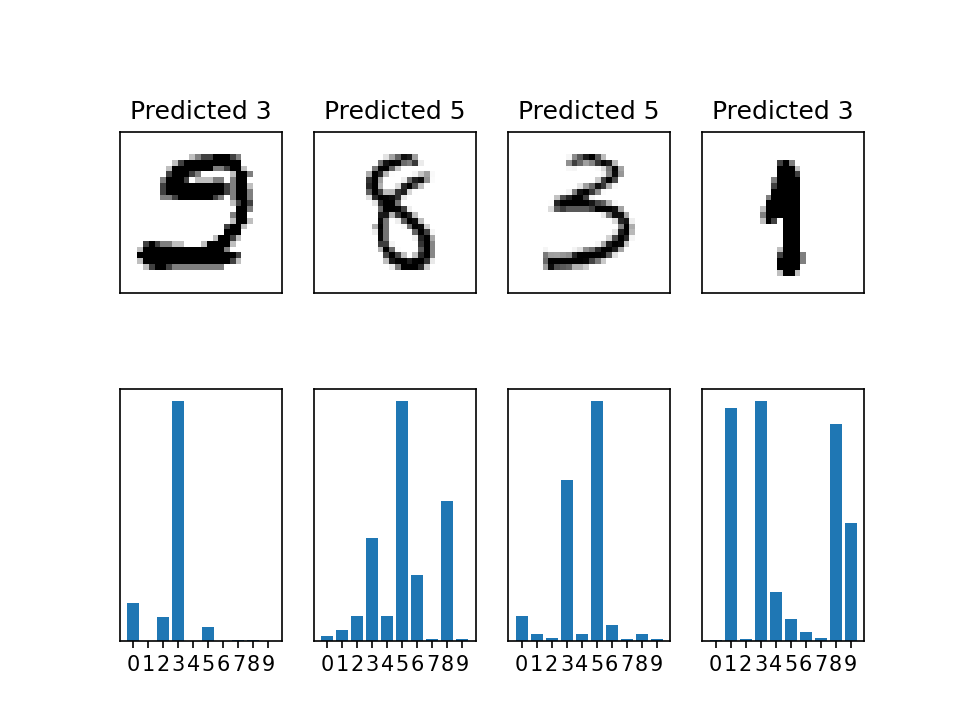

In [8]:
axes = plt.subplots(2, 4)[1] 

# More details about zip() function here https://docs.python.org/3.3/library/functions.html#zip
y_pred = clf4.predict(X_test)
j = 0 # Index which iterates over plots
for true_label, pred_label, image in list(zip(y_test, y_pred, X_test)):
    if j == 4: # We only want to look at 4 first mistakes
        break
    if true_label != pred_label:
        # Plotting predicted probabilities
        #axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1)))  # MISTAKE !
        axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1))[0]) # CORRECTION ! 
        axes[1, j].set_xticks(np.arange(10))
        axes[1, j].set_yticks([])
        
        # Plotting the image
        axes[0, j].imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        axes[0, j].set_xticks([])
        axes[0, j].set_yticks([])
        axes[0, j].set_title('Predicted {}'.format(pred_label))
        j += 1

## Changing the Loss function

It often happens that the accuracy is not the right way to evaluate the performance. ```sklearn``` has a large variety of other metrics both in classification and regression. See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

Here we want to understand how to change the cross-validation metric with minimal effort.

In [79]:
# SVM Classifier + Pipeline + New score function

pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters4 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
balanced_scorer = make_scorer(balanced_accuracy_score)

clf4 = GridSearchCV(pipe, parameters3, cv=3, scoring=balanced_scorer)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf4.best_score_))
print('Balanced accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best Balanced accuracy in train is: 0.8612334093654231
Balanced accuracy on test is: 0.825627008328415


**Question:** What is ```balanced_accuracy_score```? Write its mathematical mathematical description.


**Answer:** 
The ```balanced_accuracy_score``` function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. Thus for balanced datasets, the score is equal to accuracy.

In the *binary case*, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores:

$$
\texttt{balanced-accuracy} = \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )
$$

If the classifier performs equally well on either class, this term reduces to the conventional accuracy (i.e., the number of correct predictions divided by the total number of predictions).

In contrast, if the conventional accuracy is above chance only because the classifier takes advantage of an imbalanced test set, then the balanced accuracy, as appropriate, will drop to $\frac{1}{n_{classes}}$

The score ranges from 0 to 1, or when `adjusted=True` is used, it rescaled to the range $\frac{1}{1-n_{classes}}$
to 1, inclusive, with performance at random scoring 0.

If $y_i$ is the true value of the $i$-th sample, and $w_i$ is the corresponding sample weight (number of observations of the $i$-th class out of the total number of observations), then we adjust the sample weight to :

$$
\hat{w}_i = \frac{w_i}{\sum_j{1(y_j = y_i) w_j}}
$$

where $1(x)$ is the indicator function. Given predicted $\hat{y}_i$ for sample $i$, balanced accuracy is defined as:

$$
balanced-accuracy(y,\hat y,w)=\frac{1}{\sum \hat w_i} \sum_i 1_{(\hat y_i = y_i)}\hat w_i
$$

With `adjusted=True`, balanced accuracy reports the relative increase from $\texttt{balanced-accuracy}(y, \mathbf{0}, w) =
\frac{1}{n\_classes}$. In the binary case, this is also known as *Youden’s J statistic*, or informedness.

*Source: [here](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).*


**In a nutshell, this function allows to take into account the case when somme classes are over or under-represented (= unbalanced data).**



In [43]:
#Let's go back to our simple example for a multiclass analysis to illustrate
#and calculate the balanced-accuracy
y_true = [0, 0, 1, 2, 3]
y_pred = [0, 1, 2, 1, 3]
print("balanced-accuracy : ", balanced_accuracy_score(y_true, y_pred))

balanced-accuracy :  0.375


Indeed, 

$$
balanced-accuracy(y,\hat y,w)=\frac{1}{\sum \hat w_i} \sum_i 1_{(\hat y_i = y_i)}\hat w_i = \frac{1}{0.5 + 0.5 + 1 + 1 + 1} \sum_i 1_{(\hat y_i = y_i)}\hat w_i = \frac{1}{4} (0.5 + 1) = \frac{3}{8} = 0.375
$$


Sometimes it is important to look at the confusion matrix of the prediction.

**Question:** What is the confusion matrix? What are the conclusions that we can draw from the ```confusion_matrix(y_test, clf4.predict(X_test))```

**Answer:** By definition a confusion matrix $C$ is such that  $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.
Here, when can see for example that : 

* 0 are well identified (all predicted as being 0's)
* 3 are sometimes (3 times out of 23) identified as 5
* 8 are also sometimes (3 times out of 17) identified as 5

In [80]:
print(confusion_matrix(y_test, clf4.predict(X_test)))

[[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  2  0]
 [ 0  0 14  1  1  0  0  0  0  0]
 [ 0  0  0 18  0  3  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 1  0  0  1  0  6  0  1  0  1]
 [ 1  2  1  0  0  0 20  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  2  0  0  2  1 21]]


# PART 2 -- Problem

The data that we have contains images with $10$ classes. Normally, accuracy is a reasonable choice of the loss function to be optimized, but in this problem we *really* do not like when digits from $\{5, 6, 7, 8, 9\}$ are predicted to be from $\{0, 1, 2, 3, 4\}$.

When writing your report on this part, include:
   1. description of your loss function
   2. description of the pipeline
   3. description of the algorithms that you used 

**Question:** Propose a loss function that would address our needs. Explain your choice.

**Answer:**

## First thought

For this problem, our **FIRST IDEA** was to define two sets :

1. Class 1 = {0,1,2,3,4} 
2. Class 0 = {5,6,7,8,9} 

In order to find a proper loss function, we use the definition of the precision score.
In fact, we want to minimize Y_pred in class 1 when Y_true in class 0 (reduce False Positive rate).

In a binary classification task, the terms ‘’positive’’ and ‘’negative’’ refer to the classifier’s prediction, and the terms ‘’true’’ and ‘’false’’ refer to whether that prediction corresponds to the external judgment (sometimes known as the ‘’observation’’). Given these definitions, we can formulate the following table:


|  | Actual : Class 1                                                     | Actual : Class 0                                                     |   |   |
|--------------------------|-------------------------------------------------------------|-------------------------------------------------------------|---|---|
| Predicted : Class 1                  | TP (True Positive) Y_true and Y_pred in Class 1             | FP (False Positive) Y_true in Class 0 and Y_pred in Class 1 |   |   |
| Predicted : Class 0                  | FN (False Negative) Y_true in Class 1 and Y_pred in Class 0 | TN (True Negative) Y_true and Y_pred in Class 0             |   |   |



In this context, we can define the notions of precision as : $\text{precision} = \frac{tp}{tp + fp},$ which is the indicator which is the most interesting to answer to this problem.

 **=> After training the model, we compare our results with the previous confusion matrix to verify that the bottom right square has evolved well : the sum of the last five lines and the first five columns should be smaller.**

In [11]:
#Define New precision score function with 2 class : Class 1 = {0,1,2,3,4} and Class 0 = {5,6,7,8,9}
def custom_precision_score(y_true, y_pred):
    #Class 1 = {0,1,2,3,4} and Class 0 = {5,6,7,8,9}
    #Calcul TP (True Positive) = y_true and y_pred in class 1
    true_positive = np.sum((y_true.astype(int) < 5 ) & (y_pred.astype(int) < 5))
    #Calcul FP (False Positive) = y_true in class 0 and y_pred in class 1
    false_positive = np.sum((y_true.astype(int) > 4) & (y_pred.astype(int) < 5))
    return true_positive / (true_positive + false_positive)

**Question:** Following above examples, make an ML pipeline that uses *your* loss function and finds appropriate classifiers.



In [12]:
def use_svc(model):
    #define the scorer
    scorer = make_scorer(custom_precision_score, greater_is_better=True)
    pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', model)])
    parameters = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
    clf = GridSearchCV(pipe, parameters, cv=3, scoring=scorer)
    clf.fit(X_train, y_train)
    return clf

In [22]:
#Tests on different models
def evaluation_model(model):
    grid = use_svc(model)
    print('Returned hyperparameter: {}'.format(grid.best_params_))
    print('Best accuracy in train is: {}'.format(grid.best_score_))
    print('Accuracy on test is: {}'.format(grid.score(X_test, y_test)))
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    print('(Check custom precision score in test is the same as accuracy : {})'.format(custom_precision_score(y_test, y_pred)))
    print('Confusion matrix: \n {}'.format(confusion_matrix(y_test, y_pred)))

In [15]:
from sklearn.svm import SVC

svc_linear = LinearSVC(max_iter=5000)
svc = SVC(max_iter=5000)

dict_of_models = {'Linear SVC': svc_linear,
                  'SVC (kernel=rbf)': svc
                  }
for name, model in dict_of_models.items():
    print('------ Model : {} ------ '.format(name))
    evaluation_model(model)

------ Model : Linear SVC ------ 
Returned hyperparameter: {'svc__C': 0.125}
Best accuracy in train is: 0.9222826688026527
Accuracy on test is: 0.9279279279279279
(Check custom precision score in test is the same as accuracy : 0.9279279279279279)
Confusion matrix: 
 [[22  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  2  0  0  0  0  0  1]
 [ 1  0 14  1  0  0  0  0  0  0]
 [ 0  0  1 20  0  0  0  0  1  1]
 [ 0  1  1  0 17  0  0  0  1  0]
 [ 1  0  0  1  0  7  0  1  0  0]
 [ 1  0  0  0  0  1 20  0  1  1]
 [ 0  0  0  0  1  0  0 14  0  1]
 [ 0  1  0  1  0  2  1  0 12  0]
 [ 0  0  0  0  2  0  0  2  1 21]]
------ Model : SVC (kernel=rbf) ------ 
Returned hyperparameter: {'svc__C': 2.0}
Best accuracy in train is: 0.9379540095272763
Accuracy on test is: 0.9629629629629629
(Check custom precision score in test is the same as accuracy : 0.9629629629629629)
Confusion matrix: 
 [[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  1  1  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  0  0  1]

The accuracy of the model obtained with the kernel rbf of SVC method seems to be better than with linear kernel.

**=> However, this method does not allow to penalize the error of classification inside the two classes (1 and 0). For example, if I predict a 0 instead of a 1 it is not penalized in the loss function whereas it should be.**

##  Second thought

Our **SECOND IDEA** was to change the loss function in another way to take into account the fact that we must penalize if we predict the wrong number even if the actual or predicted values are both small or large


In the usual classification that we made above, we used the following loss 
$$l_1(y,\hat{y}) = 1_{\hat{y} \ne y}$$

Here, we can modify a little bit to show that we do not like if $y \in H = \{5, 6, 7, 8, 9\}$ and $\hat{y} \in L = \{0, 1, 2, 3, 4\}$. 

$$
l_2(y,\hat{y}) = 1_{(\hat{y} \ne y) \& [(y \notin H) \text{ or } (\hat{y} \notin L)]} + \alpha * 1_{(\hat{y} \ne y) \& (y \in H) \& (\hat{y} \in L)}
$$

where $\alpha > 1$ reflects the aversion that you have when $y \in H$ and $\hat{y} \in L$.


In [306]:
import pandas as pd

# this function returns a vector containing the loss for each pair of (y_true, y_pred)
def my_custom_loss_func(y_true,y_pred, alpha):
    df = pd.DataFrame({'y_true': [int(s) for s in y_true],'y_pred': [int(s) for s in y_pred]})
    df['loss'] = 1* (df['y_true'] != df['y_pred'])
    df['loss'] = df['loss'] + (alpha-1)*((df['y_true'] >4) & (df['y_pred'] < 5))
    return df['loss']

In [307]:
# an example to illustrate it
y_true = ['9', '9', '9'] #we have 3 nines in the dataset
y_pred = ['9', '8', '1'] 
#the first one is well-predicted (loss 0),
#the second one is bad predicted but still high (loss 1)
#the last one is very bad predicted (with a low number) (loss alpha=2)
print(my_custom_loss_func(y_true,y_pred, alpha=2))

0    0
1    1
2    2
Name: loss, dtype: int32


Then, we need to define the scoring parameter to evaluate the predictions on the test set. All scorer objects follow the convention that higher return values are better than lower return values.

Previously we saw, two kinds of scorers : 

* The Accuracy classification score.
* The Balanced accuracy classification score. 



Here, we try to adapte theses scorers to take into account that we really don't like when $y \in H$ and $\hat{y} \in L$. We propose two new scorers : 

* The Accuracy "2" classification score. 
$$
\texttt{accuracy}_{2}(y, \hat{y}) = 1- (\frac{1}{\alpha * n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} l_2(y,\hat{y})) = 1- (\frac{1}{\alpha * n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1_{(\hat{y} \ne y) \& [(y \notin H) \text{ or } (\hat{y} \notin L)]} + \alpha * 1_{(\hat{y} \ne y) \& (y \in H) \& (\hat{y} \in L)}) 
$$

* The Balanced accuracy "2" classification score. 

$$
balanced-accuracy_2(y,\hat y,w)=1 - (\frac{1}{\alpha * \sum \hat w_i} \sum_i l_2(y,\hat{y}) \hat w_i)
$$

with still
$$
\hat{w}_i = \frac{w_i}{\sum_j{1(y_j = y_i) w_j}}
$$





In [308]:
#both functions evaluate the quality of the prediction.

#accuracy_2 function
def accuracy_2(y_true,y_pred, alpha):
    nsamples = len(y_true)
    loss = my_custom_loss_func(y_true,y_pred,alpha)
    score = 1-((1/(alpha*nsamples)) * sum(loss))
    return score

#balanced_accuracy_2 function
def balanced_accuracy_2(y_true,y_pred, alpha):
    C = confusion_matrix(y_true, y_pred, sample_weight=None)    
    with np.errstate(divide='ignore', invalid='ignore'):
        wi_hat_par_cat = 1/C.sum(axis=1)
    if np.any(np.isinf(wi_hat_par_cat)):
        wi_hat_par_cat = wi_hat_par_cat[~np.isinf(wi_hat_par_cat)]    

    wi_hat= [None] * len(y_true)
    for i in range(len(y_true)):     #np.unique(y_true):
        for j in range(len(wi_hat_par_cat)): #np.unique(y_true): 
            if y_true[i]==np.unique(y_true)[j]: 
                wi_hat[i]=wi_hat_par_cat[j]
    loss = my_custom_loss_func(y_true,y_pred,alpha)
    score = 1-((1/(alpha*sum(wi_hat))) * sum(loss*wi_hat))
    return(score)


In [365]:
# going back to the previous example to illustrate it
y_true = ['9', '9', '9'] 
y_pred = ['9', '8', '1'] 
print("accuracy_2 : ", accuracy_2(y_true,y_pred,alpha=2))
print("balanced_accuracy_2 : ", balanced_accuracy_2(y_true,y_pred,alpha=2)) 

accuracy_2 :  0.5
balanced_accuracy_2 :  0.5


**Question:** Following above examples, make an ML pipeline that uses *your* loss function and finds appropriate classifiers.

**Answer:** 

Now that we have defined the loss and the score functions, let's try to use this score with the 3 different methods (KNN, LinearSVC and LogisticRegression) of machine learning we discovered for this TP and evaluate them. Note that we still want that the sum of the last five lines and the first five columns of the confusion matrix should be smaller than before.

**=> Whereas the change of the loss doesn't change the model obtained with the knn method, with the LinearSVC, we obtained different results from the previous models, with a confusion matrix evolving in the good way (smaller sum of the bottom left quarter). See details in the code.**

In [354]:
# function which calculates the sum of the last five lines and five first columns of C
def sum_unwanted(clf):
    C=confusion_matrix(y_test, clf.predict(X_test))
    res = sum(C[5][:4])+sum(C[6][:5])+sum(C[7][:6])+sum(C[8][:7])+sum(C[9][:8])
    return(res)

In [351]:
# function which evaluates the model
def evaluation_model(clf):
    print('Returned hyperparameter: {}'.format(clf.best_params_))
    print('Best classification accuracy2 in train is: {}'.format(clf.best_score_))
    print('Classification accuracy2 on test is: {}'.format(clf.score(X_test, y_test)))
    print('Confusion matrix: \n', confusion_matrix(y_test, clf.predict(X_test)))

### KNN

In [311]:
def use_knn(alpha, balanced=False):
    if not balanced:
        scorer = make_scorer(accuracy_2, alpha=alpha)
    else:
        scorer = make_scorer(balanced_accuracy_2, alpha=alpha)   
    knn = KNeighborsClassifier() # defining classifier
    parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # defining parameter space
    clf = GridSearchCV(knn, parameters, cv=3, scoring=scorer)
    clf.fit(X_train, y_train)
    return(clf)

Si $\alpha = 1$, we logically have the same results as the beginning of this TP: 

In [312]:
clf7_alpha1 = use_knn(alpha=1, balanced=False)
evaluation_model(clf7_alpha1)

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy2 in train is: 0.891497944721333
Classification accuracy2 on test is: 0.875
Confusion matrix: 
 [[21  0  0  0  0  0  1  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  2  0  0  0  0]
 [ 0  0  0 19  0  2  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 0  0  0  0  1  7  1  0  1  0]
 [ 0  0  0  0  0  1 23  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  1  0  1  0  0  0  0 14  1]
 [ 1  1  0  0  2  0  0  3  0 19]]


We try to increase the value of $\alpha$ that is to say to penalize more when $y \in H$ and $\hat{y} \in L$. let's try $\alpha=10$. 

In [313]:
clf7_alpha10 = use_knn(alpha=10, balanced=False)
evaluation_model(clf7_alpha10)

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy2 in train is: 0.9590000045022534
Classification accuracy2 on test is: 0.9515
Confusion matrix: 
 [[21  0  0  0  0  0  1  0  0  0]
 [ 0 26  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  2  0  0  0  0]
 [ 0  0  0 19  0  2  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 0  0  0  0  1  7  1  0  1  0]
 [ 0  0  0  0  0  1 23  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  1  0  1  0  0  0  0 14  1]
 [ 1  1  0  0  2  0  0  3  0 19]]


The accuracy is better than the previous one but, be careful, we cannot compare the two accuracies because they are not using the same formula because it depends on the value of $\alpha$.

Unfortunately, the confusion matrix does not change because the best model remains the same (`n_neighbours = 1`) and do not decrease. However, this is totally normal because the parameter `n_neighbours = 1` already corresponds to the minimum :

In [368]:
for n in [1, 2, 3, 4, 5]:
    knn = KNeighborsClassifier(n_neighbors = n);
    knn.fit(X_train, y_train)
    print('With parameter ',n, 'the sum of the left-bottom quarter of C is ', sum_unwanted(knn))

With parameter  1 the sum of the left-bottom quarter of C is  10
With parameter  2 the sum of the left-bottom quarter of C is  17
With parameter  3 the sum of the left-bottom quarter of C is  15
With parameter  4 the sum of the left-bottom quarter of C is  14
With parameter  5 the sum of the left-bottom quarter of C is  13


### LinearSVC

In [356]:
def use_svc(alpha, balanced=False,linear=True):
    #define the model
    if linear:
         model = LinearSVC(max_iter=5000)
    else:
         model =  SVC(max_iter=5000)
    #define the scorer
    if not balanced:
        scorer = make_scorer(accuracy_2, alpha=alpha)
    else:
        scorer = make_scorer(balanced_accuracy_2, alpha=alpha)  
        
    pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', model)])
    parameters = {'svc__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
    clf = GridSearchCV(pipe, parameters, cv=3, scoring=scorer)
    clf.fit(X_train, y_train)
    return(clf)

Example of the LinearSVC model with a balanced_accuracy function. With $\alpha = 1$ the results are obviously the same as previously that is to say : 

In [357]:
clf8_alpha1 = use_svc(alpha=1, balanced=True,linear=True)
evaluation_model(clf8_alpha1)

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy2 in train is: 0.8612334093654243
Classification accuracy2 on test is: 0.8256270083284148
Confusion matrix: 
 [[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  2  0]
 [ 0  0 14  1  1  0  0  0  0  0]
 [ 0  0  0 18  0  3  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 1  0  0  1  0  6  0  1  0  1]
 [ 1  2  1  0  0  0 20  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  2  0  0  2  1 21]]


We can notice that, here, the parameter of the initial model `C=0.015625`is not the one which minimizes the sum of the bottom left quarter of the confusion matrix. The minimum is $13$ for `C=0.125`.

In [369]:
for c in np.logspace(-8, 8, 17, base=2):
    model = LinearSVC(max_iter=5000,C=c)
    pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', model)])
    pipe.fit(X_train, y_train)
    print('With parameter ',c, 'the sum of the left-bottom quarter of C is ', sum_unwanted(pipe))

With parameter  0.00390625 the sum of the left-bottom quarter of C is  18
With parameter  0.0078125 the sum of the left-bottom quarter of C is  17
With parameter  0.015625 the sum of the left-bottom quarter of C is  17
With parameter  0.03125 the sum of the left-bottom quarter of C is  14
With parameter  0.0625 the sum of the left-bottom quarter of C is  15
With parameter  0.125 the sum of the left-bottom quarter of C is  13
With parameter  0.25 the sum of the left-bottom quarter of C is  14
With parameter  0.5 the sum of the left-bottom quarter of C is  15
With parameter  1.0 the sum of the left-bottom quarter of C is  14
With parameter  2.0 the sum of the left-bottom quarter of C is  16
With parameter  4.0 the sum of the left-bottom quarter of C is  16
With parameter  8.0 the sum of the left-bottom quarter of C is  16
With parameter  16.0 the sum of the left-bottom quarter of C is  16


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


With parameter  32.0 the sum of the left-bottom quarter of C is  16


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


With parameter  64.0 the sum of the left-bottom quarter of C is  16
With parameter  128.0 the sum of the left-bottom quarter of C is  16
With parameter  256.0 the sum of the left-bottom quarter of C is  16


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


With $\alpha = 1000$, we get the expected result because the best model is now the one with `C=0.125` and the confusion matrix did changed in the good way.

In [360]:
clf8_alpha1000 = use_svc(alpha=1000, balanced=True,linear=True)
evaluation_model(clf8_alpha10)

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy2 in train is: 0.9484628402030914
Classification accuracy2 on test is: 0.9211322709685881
Confusion matrix: 
 [[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  2  0]
 [ 0  0 14  1  1  0  0  0  0  0]
 [ 0  0  0 18  0  3  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 1  0  0  1  0  6  0  1  0  1]
 [ 1  2  1  0  0  0 20  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  2  0  0  2  1 21]]


### Logistic regression

In [361]:
def use_logistic(alpha, balanced=False):
    #define the scorer
    if not balanced:
        scorer = make_scorer(accuracy_2, alpha=alpha)
    else:
        scorer = make_scorer(balanced_accuracy_2, alpha=alpha)  
    pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
    parameters = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space
    clf = GridSearchCV(pipe, parameters, cv=3, scoring=scorer)
    clf.fit(X_train, y_train)
    return(clf)

Example of the LogisticRegression model with a accuracy function. First, with $\alpha = 1$ :

In [364]:
clf9_alpha1 = use_logistic(alpha=1, balanced=True)
evaluation_model(clf9_alpha1)

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy2 in train is: 0.8692423758419983
Classification accuracy2 on test is: 0.8337791822414583
Confusion matrix: 
 [[22  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  3  0  0  0  0  2  0]
 [ 0  0 13  1  1  0  1  0  0  0]
 [ 0  0  1 17  0  3  0  0  1  1]
 [ 0  1  0  0 18  0  0  0  0  1]
 [ 1  0  0  0  0  8  0  1  0  0]
 [ 1  1  1  0  0  0 20  0  1  0]
 [ 0  0  0  0  1  0  0 14  0  1]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  0  0  0  2  0 24]]


We can notice that, here, the parameter of the initial model `0.0078125` already the one which minimizes the sum of the bottom left quarter of the confusion matrix. The minimum is also the same ($13$) for `C=0.00390625`  and `C=0.25`.

In [367]:
for c in np.logspace(-8, 8, 17, base=2):
    pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000,C = c))])
    pipe.fit(X_train, y_train)
    print('With parameter ',c, 'the sum of the left-bottom quarter of C is ', sum_unwanted(pipe))

With parameter  0.00390625 the sum of the left-bottom quarter of C is  13
With parameter  0.0078125 the sum of the left-bottom quarter of C is  13
With parameter  0.015625 the sum of the left-bottom quarter of C is  16
With parameter  0.03125 the sum of the left-bottom quarter of C is  15
With parameter  0.0625 the sum of the left-bottom quarter of C is  14
With parameter  0.125 the sum of the left-bottom quarter of C is  14
With parameter  0.25 the sum of the left-bottom quarter of C is  13
With parameter  0.5 the sum of the left-bottom quarter of C is  14
With parameter  1.0 the sum of the left-bottom quarter of C is  14
With parameter  2.0 the sum of the left-bottom quarter of C is  14
With parameter  4.0 the sum of the left-bottom quarter of C is  15
With parameter  8.0 the sum of the left-bottom quarter of C is  15
With parameter  16.0 the sum of the left-bottom quarter of C is  15
With parameter  32.0 the sum of the left-bottom quarter of C is  15
With parameter  64.0 the sum of 

In [344]:
## Convertir en Markdown pour le rapport latex : copier coller dans le terminal Jupyter. 
#cd "C:\Users\Kim Antunez\Desktop\3A\ML\DM_ML\TP1"
#jupyter nbconvert --to markdown TP1_KA_IB.ipynb